# KEN1435 - Principles of Data Science | Homework Assignment 4 (HA4): Societal Mood under COVID-19 Pandemic

For this assignment, we will dive further into using sentiment analysis as a means to gauge societal reactions to major events. Here, we will be using a different sentiment analysis tool called [VADER](https://ojs.aaai.org/index.php/ICWSM/article/view/14550). This tool is an extension of a lexicon-based approach that also takes the context of the words into account. It scores texts on an affective scale from `-1` (negative) to `1` (positive). 

In our analysis, we will use an extended data set from a [study](https://www.jmir.org/2020/12/e21418/) that performed a longitudinal analysis on the mental health in the US during the COVID-19 pandemic, by focussing on the sentiment as expressed by accounts that indicated their location was one of twenty major cities in the US.

First we load the necessary python packages

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import statsmodels.formula.api as smf

tab20 = plt.get_cmap("tab20").colors

_PANDEMIC_DATE = pd.Timestamp("11 March 2020")

### Exercise 1. (*3pt*)
The file `HA4_daily_average_VADER.tsv` contains the day-to-day VADER averages for all observed tweets for that city in the data set. Moreover, `HA4_daily_num_obs.tsv` contains the number of observed tweets for each city on a daily basis. Load these files into the variables `means` and `counts`, respectively. Make sure that you convert the index from strings into a datetime format.

Use this data to calculate the daily average of VADER scores across all cities, using the colors in the variable `tab20` as colors for the individual cities. Finally, include a dashed line plot (colored: black) that shows a rolling 7 day average of the overall average time series.

#### Solution

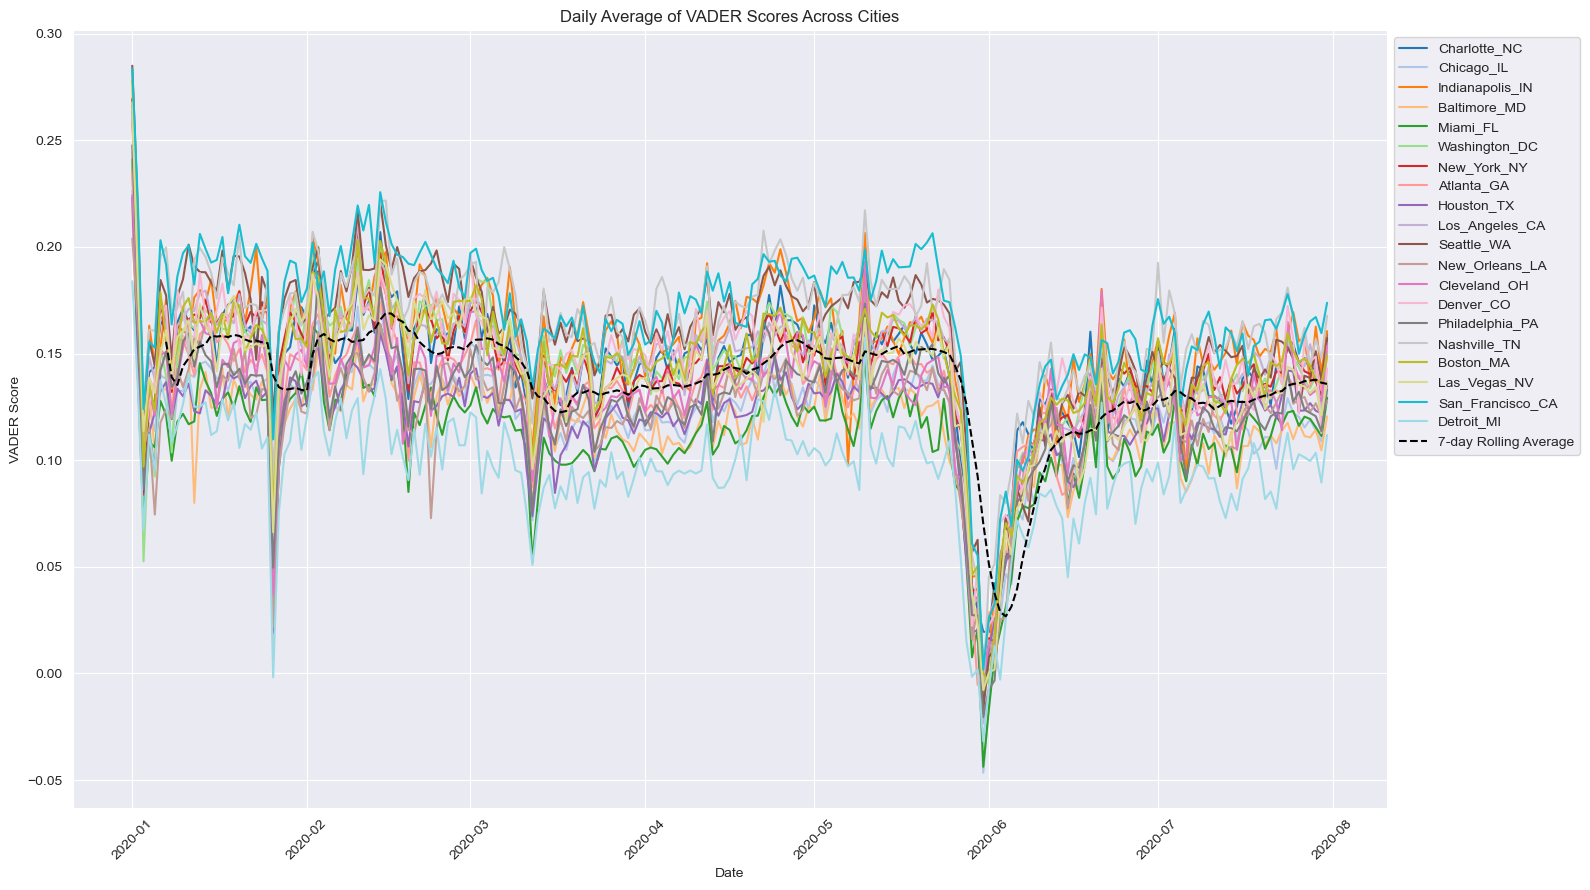

In [3]:
means = pd.read_csv("HA4_daily_average_VADER.tsv", sep="\t" , index_col=0)
counts = pd.read_csv("HA4_daily_num_obs.tsv", sep="\t", index_col=0)

means.index = pd.to_datetime(means.index)
counts.index = pd.to_datetime(counts.index)

#means.head()
#counts.head()

daily_avg = means.mean(axis=1)
rolling_avg = daily_avg.rolling(window=7).mean()

plt.figure(figsize=(16,9))
colors = plt.cm.tab20(np.linspace(0, 1, len(means.columns)))
for i, city in enumerate(means.columns):
    plt.plot(means.index, means[city], color=colors[i], label=city)

plt.plot(daily_avg.index, rolling_avg, color='black', linestyle='--', label='7-day Rolling Average')

plt.xlabel('Date')
plt.ylabel('VADER Score')
plt.title('Daily Average of VADER Scores Across Cities')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Exercise 2. (*2pt*)
Calculate the correlation coefficient between each city and the average time-series. Visualize the time-series that are the most and least correlated with the average time-series as scatter plots. Finally, include a dashed line plot (colored: black) that shows a rolling 7 day average of the overall average time series.

#### Solution

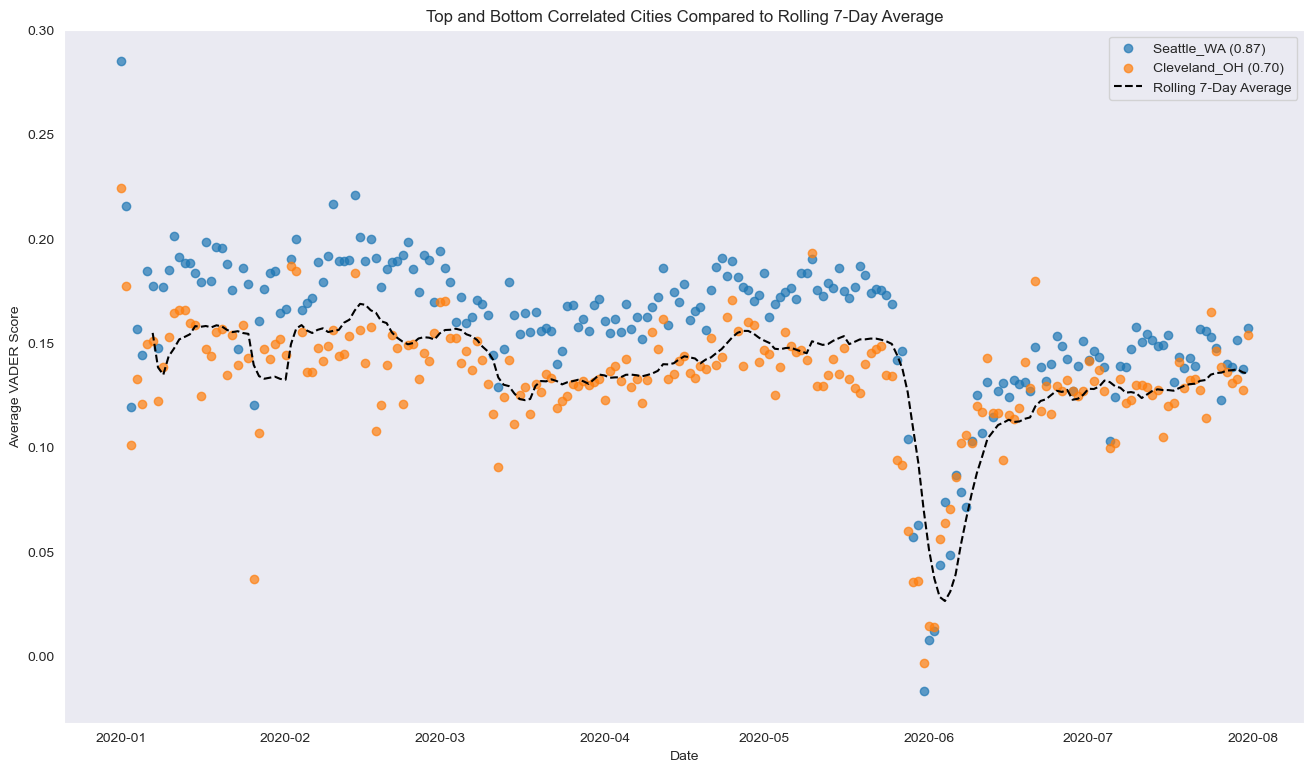

In [4]:
means["avg_scores"] = means.iloc[:, 1:].mean(axis=1)
overall_avg = means["avg_scores"].rolling(window=7).mean()
correlations = means.iloc[:, 1:].corrwith(overall_avg)

top_correlated = correlations.nlargest(1).index.tolist()
bottom_correlated = correlations.nsmallest(1).index.tolist()

plt.figure(figsize=(16, 9))

for city in (top_correlated + bottom_correlated):
    plt.scatter(overall_avg.index, means[city], alpha=0.7, label=f"{city} ({correlations[city]:.2f})")

plt.plot(overall_avg.index, overall_avg, color="black", linestyle="--", label="Rolling 7-Day Average")
plt.xlabel("Date")
plt.ylabel("Average VADER Score")
plt.title("Top and Bottom Correlated Cities Compared to Rolling 7-Day Average")
plt.legend()
plt.grid()
plt.show()

#### Exercise 3. (*2pt*)
In order to analyze the difference in societal mood before and after the COVID-19 pandemic hit, we will compare the VADER score before and after the date at which the WHO declared COVID-19 a pandemic (March 11th, 2020, stored in `_PANDEMIC_DATE`) for each city by calculating the average of the time-series both before and after March 11th, 2020. With these before and after averages per city, fit a regression model to predict the average mood after the WHO declared COVID-19 as a pandemic using the average mood before the WHO declared COVID-19 a pandemic. Print the summary of the fitted model. Finally, visualize the fitted model.

#### Solution

This was done with a custom prompted Mixtral 6x7b Model (AI):

In [6]:
means

,Charlotte_NC,Chicago_IL,Indianapolis_IN,Baltimore_MD,Miami_FL,Washington_DC,New_York_NY,Atlanta_GA,Houston_TX,Los_Angeles_CA,...,New_Orleans_LA,Cleveland_OH,Denver_CO,Philadelphia_PA,Nashville_TN,Boston_MA,Las_Vegas_NV,San_Francisco_CA,Detroit_MI,avg_scores
2020-01-01,0.263151,0.226295,0.259904,0.218967,0.241147,0.266306,0.269442,0.234863,0.223110,0.264729,...,0.203979,0.224163,0.244322,0.247677,0.261744,0.278342,0.267761,0.283774,0.183916,0.246601
2020-01-02,0.205419,0.163912,0.198417,0.143024,0.138637,0.193362,0.185787,0.162105,0.150142,0.186859,...,0.164779,0.177338,0.179899,0.175524,0.195672,0.185894,0.181756,0.220476,0.133650,0.176473
2020-01-03,0.109856,0.067881,0.107079,0.095176,0.070272,0.052560,0.083845,0.098659,0.086308,0.110361,...,0.106155,0.100903,0.103315,0.087456,0.123769,0.096954,0.113657,0.123949,0.067076,0.095501
2020-01-04,0.141171,0.123636,0.163068,0.132900,0.108618,0.117196,0.127153,0.138400,0.112829,0.148530,...,0.114843,0.132833,0.125762,0.112648,0.161182,0.135846,0.138689,0.155525,0.112108,0.132535
2020-01-05,0.143768,0.113775,0.144771,0.103959,0.106087,0.092361,0.127684,0.131992,0.122328,0.137717,...,0.074485,0.120764,0.137481,0.096113,0.160668,0.123293,0.131705,0.152812,0.095520,0.121988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,0.147938,0.115342,0.158031,0.111314,0.120403,0.137763,0.141692,0.133553,0.123336,0.144015,...,0.129643,0.135748,0.156790,0.123673,0.162061,0.147634,0.134607,0.159043,0.101333,0.135557
2020-07-28,0.142617,0.119015,0.136270,0.110675,0.119323,0.133679,0.140417,0.134899,0.126769,0.154379,...,0.122657,0.130579,0.146239,0.122143,0.144462,0.144217,0.131508,0.165084,0.099592,0.132656
2020-07-29,0.143130,0.113919,0.162603,0.114280,0.115463,0.139415,0.136851,0.144303,0.123152,0.141981,...,0.126708,0.132737,0.148612,0.120610,0.156799,0.137739,0.134506,0.167131,0.103440,0.135335
2020-07-30,0.130550,0.108671,0.140944,0.104623,0.111310,0.121804,0.130252,0.132549,0.121989,0.124499,...,0.120053,0.127580,0.112747,0.113531,0.147831,0.136122,0.120984,0.159555,0.089500,0.124313


                            OLS Regression Results                            
Dep. Variable:            pre_average   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     357.5
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           8.82e-14
Time:                        14:52:38   Log-Likelihood:                 84.146
No. Observations:                  21   AIC:                            -164.3
Df Residuals:                      19   BIC:                            -162.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0070      0.008      0.906   

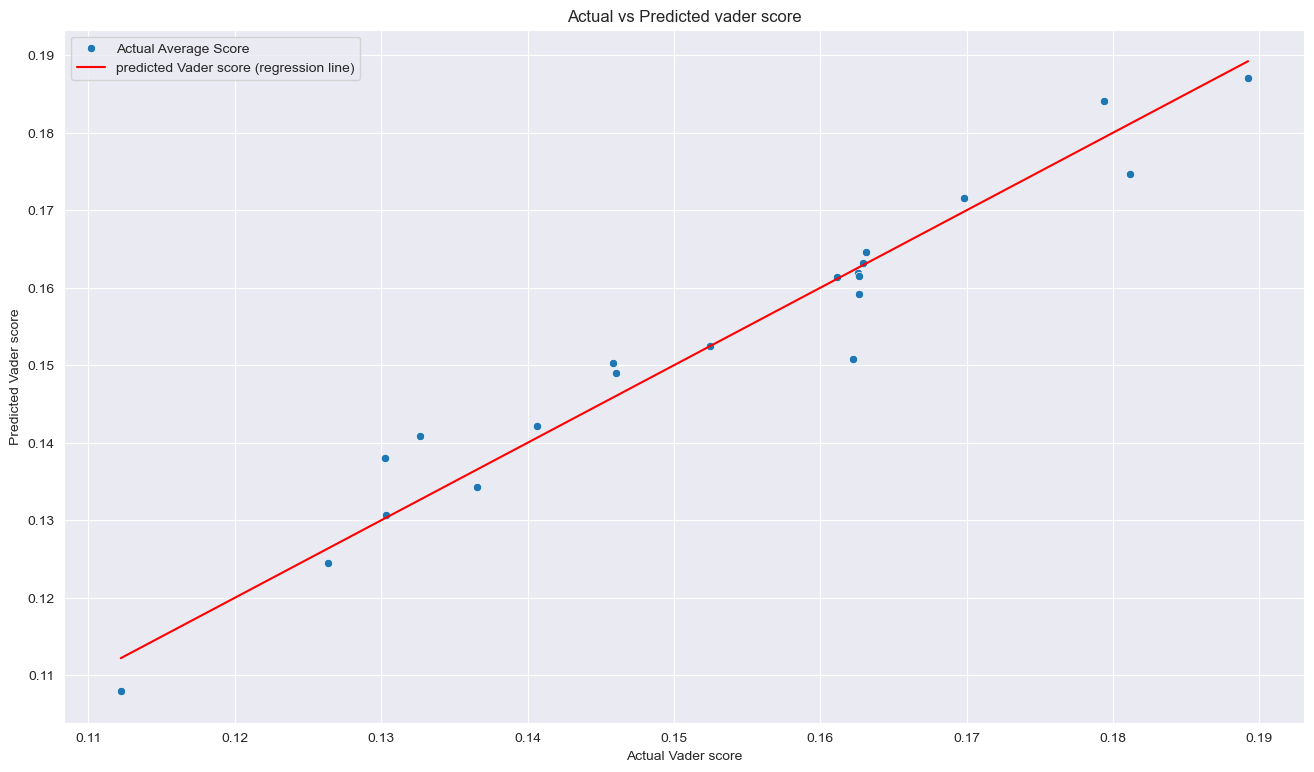

In [7]:
before_df = means.loc[:_PANDEMIC_DATE]
after_df = means.loc[_PANDEMIC_DATE:]

pre_averages = before_df.mean(axis=0)
post_averages = after_df.mean(axis=0)

pre_averages_df = pre_averages.to_frame()

post_averages_df = post_averages.to_frame()

merged_df = pre_averages_df.merge(post_averages_df, left_index=True, right_index=True)

merged_df.rename(columns={'0_x': "pre_average", '0_y': "post_average"}, inplace=True)
model = smf.ols(formula= "pre_average ~ post_average", data = merged_df)
result = model.fit()
print(result.summary())

merged_df["predicted"] = result.predict()

plt.figure(figsize=(16, 9))
sns.scatterplot(x=merged_df["pre_average"], y=merged_df["predicted"], label="Actual Average Score")
sns.lineplot(x=merged_df["pre_average"], y=merged_df["pre_average"], color="red",
             label="predicted Vader score (regression line)")
plt.xlabel("Actual Vader score")
plt.ylabel("Predicted Vader score")
plt.title("Actual vs Predicted vader score")
plt.legend()
plt.show()




### Exercise 4. (*3pt*)
As some cities were hit harder by the pandemic than others, we will investigate the impact of the demographic distribution on the difference in societal mood for all cities. Therefore, we need the demographic data that is contained in `HA4_demographics.tsv`. Using this information, determine the fraction of the population in each city that is white. Next, fit a regression model to predict the difference in average mood before and after the COVID-19 pandemic using the proportion of white inhabitants of a city. Print the summary of the fitted model. Finally, visualize the fitted model.

#### Solution

Index(['Vader_Score', 'Frac_white'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:            Vader_Score   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     6.288
Date:                Thu, 28 Mar 2024   Prob (F-statistic):             0.0220
Time:                        14:52:43   Log-Likelihood:                 52.784
No. Observations:                  20   AIC:                            -101.6
Df Residuals:                      18   BIC:                            -99.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

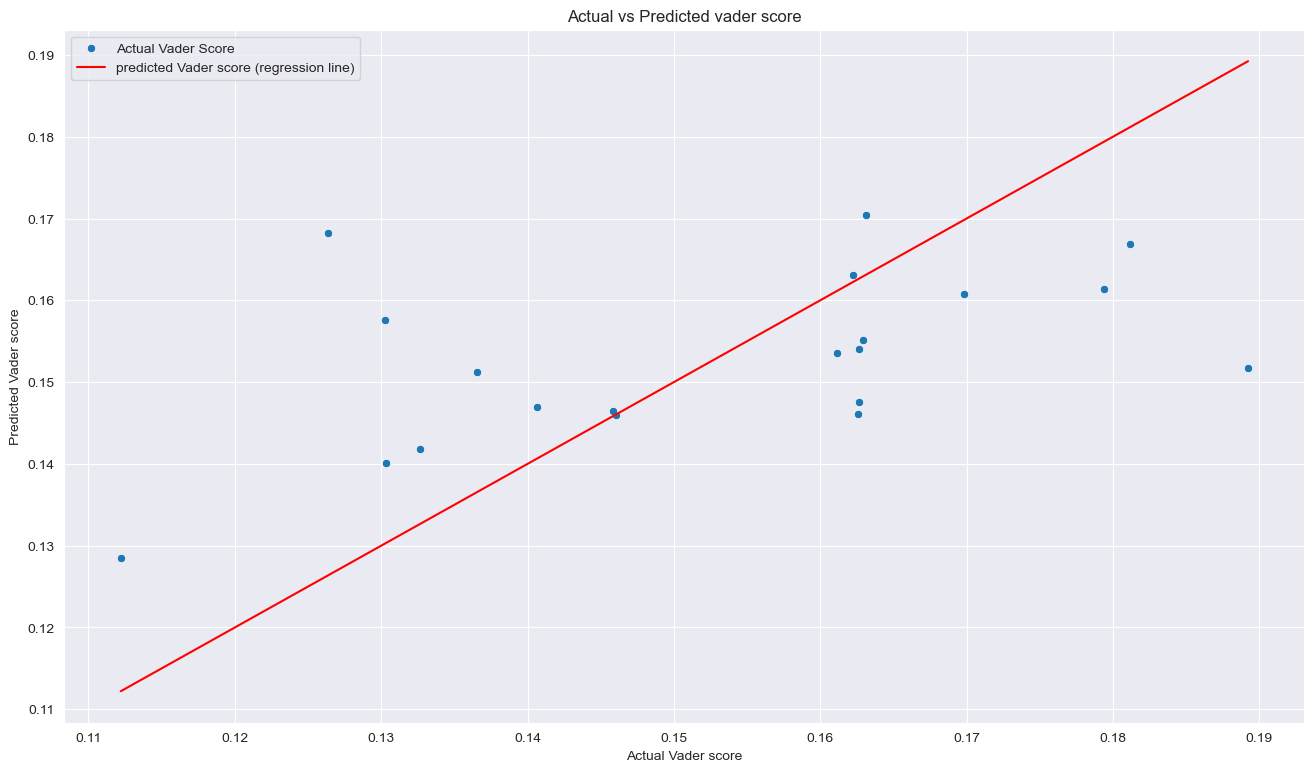

In [8]:
demographics_data = pd.read_csv('HA4_demographics.tsv', delimiter='\t')

white_population = demographics_data[demographics_data['Race'] == 'White'].groupby('City')['Count'].sum()
total_population = demographics_data.groupby('City')['Total Population'].first()

fraction_white = white_population / total_population

map_dict = {"Atlanta_GA": "Atlanta", "Baltimore_MD": "Baltimore", "Boston_MA": "Boston", "Charlotte_NC": "Charlotte",
            "Chicago_IL": "Chicago", "Cleveland_OH": "Cleveland", "Denver_CO": "Denver", "Detroit_MI": "Detroit",
            "Houston_TX": "Houston", "Indianapolis_IN": "Indianapolis", "Las_Vegas_NV": "Las Vegas",
            "Los_Angeles_CA": "Los Angeles", "Miami_FL": "Miami", "Nashville_TN": "Nashville",
            "New_Orleans_LA": "New Orleans", "New_York_NY": "New York", "Philadelphia_PA": "Philadelphia",
            "San_Francisco_CA": "San Francisco", "Seattle_WA": "Seattle", "Washington_DC": "Washington"}
pre_averages.rename(index=map_dict, inplace=True)
pre_averages_df = pre_averages.to_frame()
frac_white_df = fraction_white.to_frame()
merged_white = pre_averages_df.merge(frac_white_df, left_index=True, right_index=True)
merged_white.rename(columns={'0_x': "Vader_Score", '0_y': "Frac_white"}, inplace=True)
merged_white['Vader_Score'] = pd.to_numeric(merged_white['Vader_Score'], errors='coerce')
print(merged_white.columns)
model = smf.ols(formula="Vader_Score ~ Frac_white", data=merged_white)
result = model.fit()
summary = result.summary()
print(summary)
merged_white["predicted"] = result.predict()
plt.figure(figsize=(16, 9))
sns.scatterplot(x=merged_white["Vader_Score"], y=merged_white["predicted"], label="Actual Vader Score")
sns.lineplot(x=merged_white["Vader_Score"], y=merged_white["Vader_Score"], color="red",
             label="predicted Vader score (regression line)")
plt.xlabel("Actual Vader score")
plt.ylabel("Predicted Vader score")
plt.title("Actual vs Predicted vader score")
plt.legend()
plt.show()